In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')

# Load Data

In [75]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/flowFeatures.csv', usecols=lambda x: x not in ['publicIP', 'FlowID', 'SrcPort', 'DstPort','Timestamp','Protocol', 'FlowDuration'])

# Preprocessing

In [76]:
df = df[df['FlowPkts/s'] != np.inf]

In [77]:
for col, cnt in df.isna().sum().items():
  if cnt != 0:
    print(f"{col} have {cnt} null")

In [78]:
for name, cnt in np.isinf(df.select_dtypes(exclude=["object"])).sum().items():
  if cnt != 0:
    print(f"{name} have {cnt} infinity")

In [79]:
for col in df.columns:
  if len(df[col].unique()) == 1:
    df.drop(col, axis=1, inplace=True)

In [80]:
df = df.drop_duplicates()

In [81]:
df.shape

(1295864, 66)

# Data handling

In [82]:
def create_ip_pair(src_ip, dst_ip):
    return tuple(sorted([src_ip, dst_ip]))

# Tạo cặp IP đã sort cho việc nhóm
ip_pairs = [create_ip_pair(src, dst) for src, dst in zip(df['SrcIP'], df['DstIP'])]

In [83]:
lenpairs = set(ip_pairs)

In [84]:
# Chọn các cột số để train
numerical_columns = [col for col in df.columns
                    if col not in ['Label', 'SrcIP', 'DstIP']
                    and df[col].dtype in ['int64', 'float64']]

In [85]:
from sklearn.model_selection import train_test_split

# Chuẩn bị features
X = df[numerical_columns]
y = df['Label']

# Split data và thêm ip_pairs vào để nhóm sau này
X_train, X_test, y_train, y_test, pairs_train, pairs_test = train_test_split(
    X, y, ip_pairs, test_size=0.2, random_state=42, stratify=y
)

In [86]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [87]:
X_train_scaled.shape, y_train.shape

((1036691, 63), (1036691,))

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create sequences

In [89]:
class IPFlowDataset(Dataset):
    def __init__(self, X, y, ip_pairs, max_flows=100):
        self.max_flows = max_flows
        self.sequences = []
        self.labels = []
        self.lengths = []

        # Convert to numpy for faster processing
        X_np = X if isinstance(X, np.ndarray) else X.values
        y_np = y.values if hasattr(y, 'values') else np.array(y)

        # Group by IP pairs
        unique_pairs = set(ip_pairs)
        print(f"Number of unique IP pairs: {len(unique_pairs)}")

        for pair in unique_pairs:
            indices = [i for i, p in enumerate(ip_pairs) if p == pair]

            if len(indices) > 0:
                flows = X_np[indices]
                flow_labels = y_np[indices]

                # Tìm vị trí của các flows APT
                apt_indices = [i for i, label in enumerate(flow_labels) if label == "APT"]

                selected_indices = []
                if len(apt_indices) > 0.15*max_flows:  # Nếu có flows APT
                    # Đảm bảo lấy tất cả flows APT nếu có thể
                    if len(apt_indices) <= max_flows:
                        selected_indices.extend(apt_indices)

                        # Số lượng flows còn có thể thêm vào
                        remaining_slots = max_flows - len(selected_indices)

                        # Lấy flows xung quanh APT flows
                        surrounding_indices = set()
                        for apt_idx in apt_indices:
                            window = 10  # Số flows trước và sau mỗi APT flow
                            start = max(0, apt_idx - window)
                            end = min(len(flows), apt_idx + window + 1)
                            surrounding_indices.update(range(start, end))

                        # Loại bỏ các APT indices đã có
                        surrounding_indices = surrounding_indices - set(apt_indices)

                        # Thêm flows xung quanh
                        if surrounding_indices:
                            n_surrounding = min(remaining_slots, len(surrounding_indices))
                            selected_indices.extend(
                                np.random.choice(list(surrounding_indices),
                                               size=n_surrounding,
                                               replace=False)
                            )

                        # Nếu vẫn còn slots, thêm flows ngẫu nhiên
                        remaining_slots = max_flows - len(selected_indices)
                        if remaining_slots > 0:
                            remaining_indices = list(set(range(len(flows))) -
                                                   set(selected_indices))
                            if remaining_indices:
                                selected_indices.extend(
                                    np.random.choice(remaining_indices,
                                                   size=remaining_slots,
                                                   replace=False)
                                )
                    else:
                        # Nếu có quá nhiều APT flows, lấy ngẫu nhiên từ các APT flows
                        selected_indices = list(np.random.choice(apt_indices,
                                                              size=max_flows,
                                                              replace=False))
                else:
                    # Nếu không có flows APT, lấy ngẫu nhiên
                    if len(flows) > max_flows:
                        selected_indices = list(np.random.choice(len(flows),
                                                              size=max_flows,
                                                              replace=False))
                    else:
                        selected_indices = list(range(len(flows)))

                # Sort indices
                selected_indices = sorted(selected_indices)

                # Lấy selected flows
                if len(selected_indices) > max_flows:
                    selected_indices = selected_indices[:max_flows]

                selected_flows = flows[selected_indices]
                length = len(selected_flows)

                # Pad nếu cần
                if length < max_flows:
                    padding = np.zeros((max_flows - length, flows.shape[1]))
                    selected_flows = np.vstack([selected_flows, padding])
                elif length > max_flows:
                    selected_flows = selected_flows[:max_flows]
                    length = max_flows

                self.sequences.append(selected_flows)
                self.labels.append(1 if len(apt_indices) >= 0.1*max_flows else 0)
                self.lengths.append(length)

        print(f"Total sequences: {len(self.sequences)}")
        print(f"APT sequences: {sum(self.labels)}")

        # Convert to tensors
        self.sequences = torch.FloatTensor(np.array(self.sequences))
        self.labels = torch.FloatTensor(self.labels)
        self.lengths = torch.LongTensor(self.lengths)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            self.sequences[idx],
            self.labels[idx],
            self.lengths[idx]
        )

# Prepare data loaders for training

In [90]:
batch_size = 32

train_dataset = IPFlowDataset(X_train_scaled, y_train, pairs_train)
test_dataset = IPFlowDataset(X_test_scaled, y_test, pairs_test)

Number of unique IP pairs: 1804
Total sequences: 1804
APT sequences: 217
Number of unique IP pairs: 1270
Total sequences: 1270
APT sequences: 211


# GAN for generating balanced APT sequences

In [91]:
class Generator(nn.Module):
    def __init__(self, latent_dim, feature_dim):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.feature_dim = feature_dim

        self.model = nn.Sequential(
            # Layer 1
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            # Layer 2
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            # Layer 3
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            # Output layer
            nn.Linear(1024, feature_dim),
            nn.Tanh()  # Normalize outputs to [-1, 1]
        )

    def forward(self, noise):
        return self.model(noise)

In [92]:
class Discriminator(nn.Module):
    def __init__(self, feature_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, features):
        return self.model(features)

In [93]:
def train_gan(generator, discriminator, train_dataset, n_epochs=100, batch_size=32):
    # Hyperparameters
    latent_dim = 100
    lr = 0.0001
    b1 = 0.5
    b2 = 0.999

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    # Loss function
    adversarial_loss = nn.BCELoss()

    # Prepare real APT sequences
    apt_sequences = []
    apt_lengths = []
    for i in range(len(train_dataset)):
        if train_dataset.labels[i] == 1:
            apt_sequences.append(train_dataset.sequences[i])
            apt_lengths.append(train_dataset.lengths[i])

    apt_sequences = torch.stack(apt_sequences)
    apt_lengths = torch.stack(apt_lengths)

    n_apt = len(apt_sequences)
    print(f"Number of real APT sequences: {n_apt}")

    # Training
    for epoch in range(n_epochs):
        for i in range(0, n_apt, batch_size):
            batch_size_i = min(batch_size, n_apt - i)

            # Configure input
            real_seqs = apt_sequences[i:i+batch_size_i].to(device)
            real_lengths = apt_lengths[i:i+batch_size_i].to(device)

            # Create labels
            valid = torch.ones((batch_size_i, 1)).to(device)
            fake = torch.zeros((batch_size_i, 1)).to(device)

            # Generate a batch of sequences
            noise = torch.randn(batch_size_i, latent_dim).to(device)
            labels = torch.ones((batch_size_i, 1)).to(device)  # All APT

            # Generate fake sequences
            gen_seqs = generator(noise)

            # Train Discriminator
            optimizer_D.zero_grad()

            real_loss = adversarial_loss(discriminator(real_seqs.view(batch_size_i, -1)), valid)
            fake_loss = adversarial_loss(discriminator(gen_seqs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            g_loss = adversarial_loss(discriminator(gen_seqs), valid)

            g_loss.backward()
            optimizer_G.step()

        if (epoch + 1) % 10 == 0:
            print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    return generator

In [94]:
# Initialize và train GAN
latent_dim = 100
feature_dim = train_dataset.sequences.size(-1) * train_dataset.sequences.size(1)  # Total features in a sequence
generator = Generator(latent_dim, feature_dim).to(device)
discriminator = Discriminator(feature_dim).to(device)

In [95]:
# Train GAN
generator = train_gan(generator, discriminator, train_dataset)

Number of real APT sequences: 217
[Epoch 10/100] [D loss: 0.6109] [G loss: 0.8128]
[Epoch 20/100] [D loss: 0.5044] [G loss: 0.9388]
[Epoch 30/100] [D loss: 0.5968] [G loss: 0.8191]
[Epoch 40/100] [D loss: 0.6287] [G loss: 0.7825]
[Epoch 50/100] [D loss: 0.5102] [G loss: 0.8437]
[Epoch 60/100] [D loss: 0.5447] [G loss: 0.9759]
[Epoch 70/100] [D loss: 0.6030] [G loss: 0.8838]
[Epoch 80/100] [D loss: 0.5868] [G loss: 0.9900]
[Epoch 90/100] [D loss: 0.5887] [G loss: 1.0238]
[Epoch 100/100] [D loss: 0.4906] [G loss: 1.0447]


In [96]:
# Generate synthetic APT sequences
n_synthetic = int(len(train_dataset.sequences) - 2 * sum(train_dataset.labels).item())  # Convert to integer
print(f"Generating {n_synthetic} synthetic sequences")

noise = torch.randn(n_synthetic, latent_dim).to(device)
# labels = torch.ones((n_synthetic, 1)).to(device) #CGAN

Generating 1370 synthetic sequences


In [97]:
with torch.no_grad():
    # gen_seqs = generator(noise, labels) #CGAN
    gen_seqs = generator(noise) #GAN
    gen_seqs = gen_seqs.view(n_synthetic, train_dataset.sequences.size(1), -1)

In [98]:
# Add synthetic sequences to training data
train_dataset.sequences = torch.cat([train_dataset.sequences, gen_seqs.cpu()], dim=0)
train_dataset.labels = torch.cat([train_dataset.labels, torch.ones(n_synthetic)], dim=0)
train_dataset.lengths = torch.cat([train_dataset.lengths, torch.full((n_synthetic,), train_dataset.sequences.size(1), dtype=torch.long)], dim=0)

In [99]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True
)

# LSTM + Switch Transformer

In [100]:
class Expert(nn.Module):
  def __init__(self, d_model, hidden_dim):
    super(Expert, self).__init__()
    self.input_projection = nn.Linear(d_model, hidden_dim)
    self.output_projection = nn.Linear(hidden_dim, d_model)
  def forward(self, x):
    x = F.relu(self.input_projection(x))
    return self.output_projection(x)

In [101]:
class GatingNetwork(nn.Module):
  def __init__(self, d_model, num_experts):
    super(GatingNetwork, self).__init__()
    self.gate = nn.Linear(d_model, num_experts)
  def forward(self, x):
    return F.softmax(self.gate(x), dim=-1)

In [102]:
class MoELayer(nn.Module):
  def __init__(self, d_model, hidden_dim, num_experts, top_k=2):
    super(MoELayer, self).__init__()
    self.experts = nn.ModuleList([Expert(d_model, hidden_dim) for _ in range(num_experts)])
    self.gate = GatingNetwork(d_model, num_experts)
    self.num_experts = num_experts
    self.top_k = top_k
  def forward(self, x):
    batch_size, seq_len, d_model = x.shape
    gating_scores = self.gate(x)
    top_k_scores, top_k_indices = torch.topk(gating_scores, self.top_k, dim=-1)
    top_k_scores_normalized = top_k_scores / top_k_scores.sum(dim=-1, keepdim=True)

    output = torch.zeros_like(x)
    for i in range(self.num_experts):
      mask = (top_k_indices == i).float()
      if mask.any():
        position_using_expert = mask.any(dim=-1)
        if position_using_expert.any():
          expert_input = x[position_using_expert]
          expert_output = self.experts[i](expert_input)
          expert_weights = torch.zeros(batch_size, seq_len, device=x.device)
          for k in range(self.top_k):
            mask_k = (top_k_indices[..., k] == i)
            expert_weights[mask_k] = top_k_scores[..., k][mask_k]
          weighted_output = torch.zeros_like(x, dtype=expert_output.dtype)
          weighted_output[position_using_expert] = expert_output
          output += weighted_output * expert_weights.unsqueeze(-1)
    return output

In [103]:
class SwitchTransformer(nn.Module):
  def __init__(self, d_model, nhead, num_experts, hidden_dim, dropout=0.1, top_k=2, batch_first=False):
    super(SwitchTransformer, self).__init__()
    self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
    self.moe = MoELayer(d_model, hidden_dim, num_experts, top_k=top_k)
    self.dropout = nn.Dropout(dropout)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
  def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
    src2 = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
    src = src + self.dropout(src2)
    src = self.norm1(src)
    src2 = self.moe(src)
    src = src + self.dropout(src2)
    src = self.norm2(src)
    return src

In [104]:
class ELModel(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(ELModel, self).__init__()

        # Feature Extraction
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0.3
        )

        # Transformer Encoder
        encoder_layer = SwitchTransformer(
            d_model=hidden_size,
            nhead=8,
            num_experts=5,
            hidden_dim=hidden_size,
            dropout=0.3,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=1
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, lengths):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Feature extraction
        x = self.feature_extractor(x)  # (batch, seq_len, hidden_size)

        # Sort sequences by length for packed sequence
        lengths_cpu = lengths.cpu()
        lengths_sorted, indices = torch.sort(lengths_cpu, descending=True)
        x_sorted = x[indices]

        # Pack sequence for LSTM
        packed_x = nn.utils.rnn.pack_padded_sequence(
            x_sorted, lengths_sorted, batch_first=True
        )

        # BiLSTM
        lstm_out, _ = self.lstm(packed_x)

        # Unpack LSTM output
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(
            lstm_out, batch_first=True, total_length=seq_len
        )

        # Restore original order
        _, restore_indices = torch.sort(indices)
        lstm_out = lstm_out[restore_indices]

        # Create attention mask for transformer
        # False indicates valid position, True indicates padding
        key_padding_mask = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1).to(x.device)
        key_padding_mask = key_padding_mask >= lengths.unsqueeze(-1)

        # Transformer encoding
        transformer_out = self.transformer(
            lstm_out,
            src_key_padding_mask=key_padding_mask
        )  # (batch, seq_len, hidden_size)

        # Mask out padding before pooling
        mask = (~key_padding_mask).float().unsqueeze(-1)
        transformer_out = transformer_out * mask

        # Global average pooling over sequence length
        # First transpose to get sequence length at the last dimension
        pooled = transformer_out.sum(dim=1) / lengths.float().unsqueeze(-1)

        # Classification
        return self.classifier(pooled)


In [105]:
@torch.cuda.amp.autocast()
def train_epoch(model, train_loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch_flows, batch_labels, batch_lengths in train_loader:
        batch_flows = batch_flows.to(device)
        batch_labels = batch_labels.to(device)
        batch_lengths = batch_lengths.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(batch_flows, batch_lengths)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch_labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        preds = torch.sigmoid(outputs.detach())
        preds = (preds > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    return {
        'loss': total_loss / len(train_loader),
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds)
    }

@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    for batch_flows, batch_labels, batch_lengths in test_loader:
        batch_flows = batch_flows.to(device)
        batch_lengths = batch_lengths.to(device)

        outputs = model(batch_flows, batch_lengths)
        outputs = outputs.view(-1)

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.numpy())

    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds)
    }

def train_model(model, train_loader, test_loader, epochs=10):
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]).to(device))
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.0001,
        weight_decay=0.01
    )

    scaler = torch.cuda.amp.GradScaler()
    best_f1 = 0
    patience = 10
    no_improve = 0

    for epoch in range(epochs):
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, scaler)

        # Evaluate
        test_metrics = evaluate(model, test_loader)

        # Early stopping
        if test_metrics['f1'] > best_f1:
            best_f1 = test_metrics['f1']
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            model.load_state_dict(best_state)
            break

        # Print metrics
        print(f'\nEpoch {epoch+1}/{epochs}')
        print(f'Train - Loss: {train_metrics["loss"]:.4f}, Acc: {train_metrics["accuracy"]:.4f}, '
              f'Prec: {train_metrics["precision"]:.4f}, Rec: {train_metrics["recall"]:.4f}, '
              f'F1: {train_metrics["f1"]:.4f}')
        print(f'Test  - Acc: {test_metrics["accuracy"]:.4f}, Prec: {test_metrics["precision"]:.4f}, '
              f'Rec: {test_metrics["recall"]:.4f}, F1: {test_metrics["f1"]:.4f}')

    # Final evaluation
    model.eval()
    final_metrics = evaluate(model, test_loader)
    print("\nFinal Test Results:")
    print(f"Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f}")
    print(f"Recall: {final_metrics['recall']:.4f}")
    print(f"F1 Score: {final_metrics['f1']:.4f}")

    return model, final_metrics

# Training and evaluate

In [106]:
# Initialize model
input_size = X_train_scaled.shape[1]  # Số features gốc
model = ELModel(input_size).to(device)

# Train model với các hàm train_epoch và evaluate đã có
train_model(model, train_loader, test_loader)


Epoch 1/10
Train - Loss: 0.6839, Acc: 0.7127, Prec: 0.6355, Rec: 0.9975, F1: 0.7764
Test  - Acc: 0.9598, Prec: 0.8279, Rec: 0.9573, F1: 0.8879

Epoch 2/10
Train - Loss: 0.1313, Acc: 0.9849, Prec: 0.9730, Rec: 0.9975, F1: 0.9851
Test  - Acc: 0.9882, Prec: 0.9455, Rec: 0.9858, F1: 0.9652

Epoch 3/10
Train - Loss: 0.0606, Acc: 0.9934, Prec: 0.9882, Rec: 0.9987, F1: 0.9934
Test  - Acc: 0.9953, Prec: 0.9724, Rec: 1.0000, F1: 0.9860

Epoch 4/10
Train - Loss: 0.0368, Acc: 0.9978, Prec: 0.9962, Rec: 0.9994, F1: 0.9978
Test  - Acc: 0.9976, Prec: 0.9860, Rec: 1.0000, F1: 0.9929

Epoch 5/10
Train - Loss: 0.0284, Acc: 0.9984, Prec: 0.9969, Rec: 1.0000, F1: 0.9984
Test  - Acc: 0.9976, Prec: 0.9906, Rec: 0.9953, F1: 0.9929

Epoch 6/10
Train - Loss: 0.0235, Acc: 0.9987, Prec: 0.9975, Rec: 1.0000, F1: 0.9987
Test  - Acc: 0.9984, Prec: 0.9906, Rec: 1.0000, F1: 0.9953

Epoch 7/10
Train - Loss: 0.0203, Acc: 0.9978, Prec: 0.9962, Rec: 0.9994, F1: 0.9978
Test  - Acc: 0.9984, Prec: 0.9906, Rec: 1.0000, F1:

(ELModel(
   (feature_extractor): Sequential(
     (0): Linear(in_features=63, out_features=128, bias=True)
     (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
     (2): ReLU()
     (3): Dropout(p=0.3, inplace=False)
   )
   (lstm): LSTM(128, 128, batch_first=True, dropout=0.3)
   (transformer): TransformerEncoder(
     (layers): ModuleList(
       (0): SwitchTransformer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (moe): MoELayer(
           (experts): ModuleList(
             (0-4): 5 x Expert(
               (input_projection): Linear(in_features=128, out_features=128, bias=True)
               (output_projection): Linear(in_features=128, out_features=128, bias=True)
             )
           )
           (gate): GatingNetwork(
             (gate): Linear(in_features=128, out_features=5, bias=True)
           )
         )
         (dropout): Dropout(p=0.

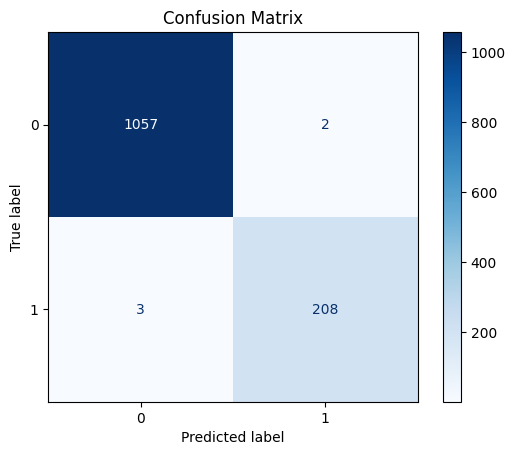

In [107]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Sau khi model đã được huấn luyện và đánh giá, sử dụng hàm evaluate để lấy dự đoán
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_flows, batch_labels, batch_lengths in test_loader:
            batch_flows = batch_flows.to(device)
            batch_lengths = batch_lengths.to(device)

            outputs = model(batch_flows, batch_lengths)
            outputs = outputs.view(-1)

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.numpy())

    # Tính toán confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])

    # Hiển thị confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Gọi hàm để hiển thị confusion matrix
plot_confusion_matrix(model, test_loader)